# Event Price Predictions using the Ticketmaster API
## Final Project
### Priya Aggarwal and Shreya Rajeswaran (DS3000 Section 4)

In this project, we hope to explore the ticketmaster API and develop machine learning models to better understand the pricing dynamics of concert ticketing within Boston.

1. Can we create an accurate model to predict ticket prices based on variables such as season, genre, ticket_limit, etc?
2. Is there a relationship between the genre of an event and its price?

### Getting data from API

The pipeline includes:
1. Using `request_event_data` to convert Ticketmaster API data for a specific city into a workable dictionary
2. Using `build_event_dict` which gets specific feature information from the dictionary as well as clean up certain variables to make them more usable

First, we queried the API using specific parameters that were obtained from the [Ticketmaster API documentation website.](https://developer.ticketmaster.com/products-and-docs/apis/getting-started/)

The parameters we filtered by included:
- events (grabs all information from the events table)
- classificationName = Music (all music-related events)
- source=Ticketmaster (ensures info from Ticketmaster rather than other sources)
- size=200 (maximum call the API allows)
- city=Boston (only Boston)

This allowed us to obtain information about 200 music-related concerts and events that happened in Boston over the past year.

In [1]:
import requests
import json
import statistics
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm 
import scipy.stats as stats
import pylab as py
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
def request_event_data(city):
    """ grabs music event data from ticketmaster API about a specific city
    
    Args:
        city (string): specific city of interest
    
    Returns 
        json_dict (dict): dict of raw API data
    
    """
    apikey = 'tFjIS63e1TIhsU3DfA43JipgxnPG9GDi'
    url = f'https://app.ticketmaster.com/discovery/v2/events.json?classificationName=Music&source=Ticketmaster&size=200&city={city}&apikey={apikey}'
    
    url_text = requests.get(url).text
    json_dict = json.loads(url_text)
    
    return json_dict

### Creating a dataframe

Once we obtained a JSON dictionary of all of the events information, we needed to index into it to create a dataframe with all our features of interest. The below code cells display this process.

In [3]:
def obtain_integer(string):
    """ looks inside of a string and compiles all the integers together into a number
    Will be used to obtain the integer ticket limit from a string with that info
    
    Parameters:
        string (string): string that contains a numeric value inside it
    
    Returns:
        Integer: an integer compiled of numbers found in the string
    """
    
    # obtain a string of only the numeric values within the string
    numeric_string = ''.join(x for x in string if x.isdigit())
    
    # return the value as an integer
    if numeric_string == '':
        return 0;
    else:
        return int(numeric_string)


def obtain_season(date):
    """takes an input date and returns which season it is in
    
    Parameters:
        date (string): the date being inspected in YYYY-MM-DD format

    Returns:
        season (string): A string representation of the season of the given date
    """

    # convert date to a datetime object and obtain which day of the year it is
    date = datetime.strptime(date, '%Y-%m-%d')
    doy = date.timetuple().tm_yday
    
    # set variables for different seasons according to the day of year
    spring = range(80, 172)
    summer = range(172, 264)
    fall = range(264, 355)
    
    # return the season that doy is in
    if doy in spring:
        return 'spring'
    elif doy in summer:
        return 'summer'
    elif doy in fall:
        return 'fall'
    else:
        return 'winter'
    
def look_for_age_restriction(event_title):
    """ looks to see if there is an age restriction in an event title
    
    Args: 
        event_title (string): the name of the event
    
    Returns:
        boolean representing if there is an age restriction (True) or not (False)
    """
    for i in range(len(event_title)):
        # looks for a string that is 2 digits followed by a + (ex. 18+, 21+, etc.)
        if event_title[i] == '+':
            if event_title[i - 2].isdigit() and event_title[i - 1].isdigit():
                return True

    return False

In [4]:
# dict of Boston venue sizes:
# information was obtained from google / online sources
venue_size = {'Brighton Music Hall presented by Citizens': 500,
              'Paradise Rock Club presented by Citizens': 933,
              'The Grand (Boston)': 800,
              'Boch Center Wang Theatre': 3500,
              'Citizens House of Blues Boston': 2200,
              'Big Night Live': 2000,
              'MGM Music Hall at Fenway': 5000,
              'TD Garden': 19580,
              'The Wilbur': 1200,
              'Orpheum Theatre presented by Citizens': 2700,
              'Agganis Arena': 7200,
              'Fenway Park': 37755,
              'Royale Boston': 1500,
              'Leader Bank Pavilion': 5000,
              'Boch Center Shubert Theatre': 1500,
              'Legacy': 400,
              'Boston Gliderdrome': 3100}

In [5]:
# obtain feature info from json and append to dict values
def build_event_dict(json_dict, venue_size_dict):
    """ given raw API json information, extracts features of interest and builds a clean dictionary
    
    Args:
        json_dict (dict): dictionary with API data
        venue_size_dict (dict): dict with data on different venue sizes relevant to city of interest
        
    Returns:
        ticketmaster_dict (dict): clean dict with features of interest
    """
    
    #initializing dict to store feature information    
    ticketmaster_dict = {'venue_id': list(),
                    'venue_name': list(),
                    'event_id': list(),
                    'event_name': list(),
                    'avg_price': list(),
                    'season': list(),
                    'genre': list(),
                    'subgenre': list(),
                    'ticket_limit': list(),
                    'age_restriction': list(),
                    'venue_size': list(),
                    'promoter': list()}

    for event in json_dict['_embedded']['events']:
        
        # avg price - using try and except because some events do not have price info
        try:
            avg_price = statistics.mean([event['priceRanges'][0]['min'], event['priceRanges'][0]['max']])
            ticketmaster_dict['avg_price'].append(avg_price)
        except:
            ticketmaster_dict['avg_price'].append(np.nan)
        
        # venue_id, name, and size
        ticketmaster_dict['venue_id'].append(event['_embedded']['venues'][0]['id'])
        venue_name = event['_embedded']['venues'][0]['name']
        ticketmaster_dict['venue_name'].append(venue_name)
        ticketmaster_dict['venue_size'].append(venue_size_dict[venue_name])
        
        # event id and name
        ticketmaster_dict['event_id'].append(event['id'])
        ticketmaster_dict['event_name'].append(event['name'])
        
        # season - using obtain_season function from above
        ticketmaster_dict['season'].append(obtain_season(event['dates']['start']['localDate']))
        
        # genre and subgenre
        ticketmaster_dict['genre'].append(event['classifications'][0]['genre']['name'])
        ticketmaster_dict['subgenre'].append(event['classifications'][0]['subGenre']['name'])
        
        # ticket limit - using obtain_integer function from above. 
        # again using try and except because some events don't have ticket limit info
        try:
            ticketmaster_dict['ticket_limit'].append(obtain_integer(event['ticketLimit']['info']))
        except:
            ticketmaster_dict['ticket_limit'].append(np.nan)
    
        # add age restriction, also double check with event name
        if look_for_age_restriction(event['name']):
            ticketmaster_dict['age_restriction'].append(True)
        else:
            ticketmaster_dict['age_restriction'].append(event['ageRestrictions']['legalAgeEnforced'])
            
        # promoter info
        try:
            ticketmaster_dict['promoter'].append(event['promoter']['name'])
        except:
            ticketmaster_dict['promoter'].append(np.nan)
            
    return ticketmaster_dict

In [6]:
# call all functions
json_dict = request_event_data('Boston')
ticketmaster_dict = build_event_dict(json_dict, venue_size)
ticketmaster_df = pd.DataFrame.from_dict(ticketmaster_dict)

# print df
ticketmaster_df

,venue_id,venue_name,event_id,event_name,avg_price,season,genre,subgenre,ticket_limit,age_restriction,venue_size,promoter
0,KovZpa2gne,TD Garden,vvG17Z9ww45oYO,Kiss 108s Jingle Ball Presented By Capital One,277.5,fall,Rock,Pop,8.0,False,19580,PROMOTED BY VENUE
1,KovZpa2gne,TD Garden,vvG17Z9xCMa7kG,Madonna - The Celebration Tour,311.5,winter,Rock,Pop,8.0,False,19580,LIVE NATION MUSIC
2,KovZpa2gne,TD Garden,vvG17Z9cp1VomN,Doja Cat - The Scarlet Tour,139.5,fall,Hip-Hop/Rap,French Rap,4.0,False,19580,LIVE NATION MUSIC
3,KovZpa2gne,TD Garden,vvG17Z9Sif-IJx,Mariah Carey - Merry Christmas One And All!,283.2,fall,Pop,Pop,NaN,False,19580,LIVE NATION MUSIC
4,KovZpa2gne,TD Garden,vvG17Z9UrBEUDT,Melanie Martinez: The Trilogy Tour,89.5,spring,Rock,Pop,68.0,False,19580,LIVE NATION MUSIC
...,...,...,...,...,...,...,...,...,...,...,...,...
195,KovZpZA11JtA,Paradise Rock Club presented by Citizens,vvG17Z9UjtGnpo,SiM: PLAYDEAD World Tour,31.0,spring,Metal,Nu-Metal,4.0,False,933,CROSSROADS PRESENTS
196,KovZ917AEJz,MGM Music Hall at Fenway,vvG17Z9U9TXzeW,Boston Country Music Festival: Zeze Di Camargo,171.5,winter,Country,Country,8.0,False,5000,LIVE NATION MUSIC
197,KovZpapwne,Brighton Music Hall presented by Citizens,vvG17Z9VRiaJCq,MIGHTY MYSTIC Winter Reggae Splash (18+),25.0,winter,Reggae,Reggae,8.0,True,500,CROSSROADS PRESENTS
198,KovZpZA11JtA,Paradise Rock Club presented by Citizens,vvG17Z9V1D6s2C,Zakk Sabbath (18+),35.0,winter,Undefined,Undefined,8.0,True,933,CROSSROADS PRESENTS


Finally, we decided to deal with our NaN data.

In [7]:
ticketmaster_df.isnull().sum()

venue_id            0
venue_name          0
event_id            0
event_name          0
avg_price          13
season              0
genre               0
subgenre            0
ticket_limit        8
age_restriction     0
venue_size          0
promoter            0
dtype: int64

Because there are very few null values outside of avg_price and ticket_limit, we decided to drop those events since we still have a significant amount of data.

In [8]:
# drop all rows without avg price and ticket_limit info
ticketmaster_df.dropna(subset=['avg_price', 'ticket_limit'], inplace=True)

In [9]:
len(ticketmaster_df)

186

In [10]:
# save as a csv so that data does not keep changing
# ticketmaster_df.to_csv('ticketmaster_df.csv')

### Data visualizations

In [11]:
# import data from saved file
ticketmaster_df = pd.read_csv('ticketmaster_df.csv')

##### Visualization 1
First, we wanted to observe the distribution of average price because it's the variable we are predicting and we wanted to determine if it would work with the models we are hoping to use.

Text(0.5, 1.0, 'Distribution of average event prices in Boston')

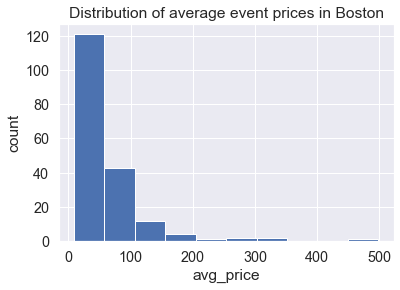

In [12]:
# plot average event price distribution as a histogram
sns.set(font_scale=1.3)
plt.hist(ticketmaster_df['avg_price'])
plt.xlabel('avg_price')
plt.ylabel('count')
plt.title('Distribution of average event prices in Boston')

After observing the above graph, we can see that the prices are very right-skewed. This suggests that if we transform the price column using log, we can get a more Normal distribution which could be better for analysis.

Text(0.5, 1.0, 'Distribution of average event prices in Boston')

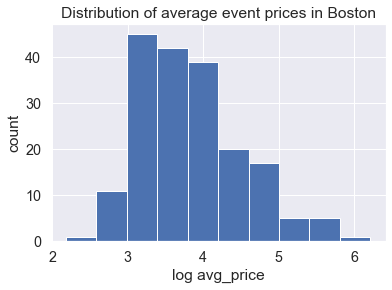

In [13]:
# transform avg_price and add to new feature in df
ticketmaster_df['price_transformed'] = np.log(ticketmaster_df['avg_price'])

# plot transformed data
plt.hist(ticketmaster_df['price_transformed'])
plt.xlabel('log avg_price')
plt.ylabel('count')
plt.title('Distribution of average event prices in Boston')

This suggests that maybe we need to use the transformed price column in our analysis for a better result.

##### Visualization 2
Next we wanted to explore the relationship between genre and avg_price. We decided to group by genre and plot a bar chart of each genre's average avg_price across all events.

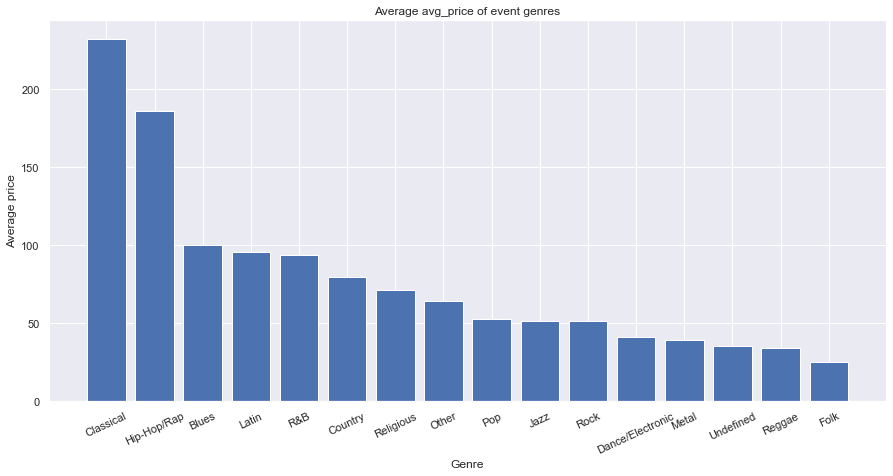

In [14]:
# obtain dataframe with genre and average price within that genre
genre_price_df = ticketmaster_df.groupby('genre').mean()['avg_price'].reset_index()

# sort by decreasing avg price
genre_price_df = genre_price_df.sort_values(by=['avg_price'], ascending=False)

# plot as a bar chart
sns.set(font_scale = 1)
plt.bar(genre_price_df['genre'], genre_price_df['avg_price'])
plt.title('Average avg_price of event genres')
plt.xlabel('Genre')
plt.ylabel('Average price')
plt.xticks(rotation = 25)
plt.gcf().set_size_inches(15, 7)

After observing this visualization we can see that classical and hip hop or rap events are usually a lot more expensive than reggae or metal. We were surprised that pop events were so low because we feel like they are usually expensive; however, maybe famous artists play in venues just outside of Boston that are larger, but are not considered "Boston" locations.

### Implementing ML - Linear Regression

#### Identifying predictor features

Upon trying various different versions of ML algorithms to predict the price of an event, we have decided to use a linear regression with the features ticket limit, venue size, genre, and season.

To begin our analysis, we need to create dummy variables of our categorical features and combine all the features into a matrix with a bias column.

In [15]:
# obtain dummy variables for genre and season
genre_dummies_df = pd.get_dummies(ticketmaster_df.genre, columns=['genre'], prefix='genre', dtype = int)
season_dummies_df = pd.get_dummies(ticketmaster_df.season, columns=['season'], prefix='season', drop_first = True, dtype = int)

Looking at the genre distribution, we can see that there are many rock and pop events within our dataset. Our dataset also contains many genres with only one of two events. Since we need to drop one of the dummy variables to conduct a linear regression, we decided to drop all the events with only one or two data points to combine them into an "Other" category. This is because it will be difficult to accurately decide these genres' impacts on the price if this model was used on data points outside of our dataset.

In [16]:
genre_dummies_df.sum()

genre_Blues                 1
genre_Classical             1
genre_Country              12
genre_Dance/Electronic      9
genre_Folk                  1
genre_Hip-Hop/Rap           8
genre_Jazz                  1
genre_Latin                 1
genre_Metal                 6
genre_Other                 1
genre_Pop                  26
genre_R&B                   3
genre_Reggae                2
genre_Religious             1
genre_Rock                112
genre_Undefined             1
dtype: int64

In [17]:
# write out list of genres with only 1 or 2 events in the dataset
genre_list_drop = ['genre_Blues', 'genre_Classical', 'genre_Jazz', 'genre_Latin', 'genre_Folk',
                   'genre_Other', 'genre_R&B', 'genre_Reggae', 'genre_Religious', 'genre_Undefined']

# update genre dummies df to drop those genres
genre_dummies_df = genre_dummies_df.drop(columns = genre_list_drop)
genre_dummies_df.head()

,genre_Country,genre_Dance/Electronic,genre_Hip-Hop/Rap,genre_Metal,genre_Pop,genre_Rock
0,0,0,0,0,0,1
1,0,0,0,0,0,1
2,0,0,1,0,0,0
3,0,0,0,0,0,1
4,0,0,0,0,0,1


Above, you can see the 6 genres left within the data set as well as a list of all the genres we decided to drop from our linear regression matrix.

For the numeric features, we need to scale them by their standard deviation in order to keep equal weights within our model, since the features have different units associated with them.

In [18]:
# obtain numpy arrays for scaled numeric features
ticket_limit = (ticketmaster_df.ticket_limit/ticketmaster_df.ticket_limit.std()).to_numpy()
venue_size = (ticketmaster_df.venue_size/ticketmaster_df.venue_size.std()).to_numpy()

Finally, we can combine all of these features in an X_values matrix and extract the average price from our dataframe to create the y_values matrix.

In [19]:
# combine x values in an X matrix
X_values = np.hstack((ticket_limit.reshape(-1,1), venue_size.reshape(-1,1), genre_dummies_df.to_numpy(), season_dummies_df.to_numpy()))

# obtain average price as an array for y values
y_values = ticketmaster_df.avg_price.to_numpy()

#### Cross-validating

We started off by splitting our dataset into a simple 70-30 split to create our Linear Regression from the training dataset. This is followed up by LOOCV to more accurately test cross validate our data. We conducted the 70-30 cross validation initially since it is easy to interpret and not computationally difficult. However, since we have less than 200 rows in our dataset, we decided it would be worth completeing a LOOCV as well.

In [20]:
# conduct single fold cross validation (70-30 split)

# obtain training and testing datasets
cross_val = train_test_split(X_values, 
                             y_values,
                             train_size=0.7,
                             random_state = 12)
Xtrain, Xtest, ytrain, ytest = cross_val

In [21]:
# fit model on training data and use it to predict testing data
model = LinearRegression()
model.fit(Xtrain, ytrain)
y_preds = model.predict(Xtest)

# calculate R2 value
print('R-squared: ' + str(r2_score(ytest, y_preds)))

R-squared: 0.4853835051064138


In [22]:
# conduct LOO cross validation

# set up the array of predictions to fill out
y_preds = np.empty(len(X_values))

# loop through each observation
for obs in range(len(X_values)):
    # the below excludes the single row/true y belonging to obs as well as the bias column
    mult_trainX = np.concatenate((X_values[:obs, :], X_values[obs+1:, :]))
    mult_trainy = np.concatenate((y_values[:obs], y_values[obs+1:]))
    
    # then train the model
    loocv_regress = LinearRegression()
    loocv_regress.fit(mult_trainX, mult_trainy)
    
    # and predict the held out observation (and store it)
    y_preds[obs] = loocv_regress.predict(X_values[obs, :].reshape(-1, 11))[0]

# print out R2 score
r2_score(y_values, y_preds)

0.48994680613096864

#### Fitting model to whole dataset

After getting a satisfying R2 value from our cross validation, we decided to fit our model to the entire data set.

In [23]:
def get_mse(y_true, y_pred):
    # calculate the mean squared distance between the predicted and actual y
    return np.mean((y_pred - y_true) ** 2)

In [24]:
# fit model to overall data
model = LinearRegression()
model.fit(X_values, y_values)
y_preds = model.predict(X_values)

print('MSE: ' + str(get_mse(y_values, y_preds)))
print('R-squared: ' + str(r2_score(y_values, y_preds)))

MSE: 1405.9839952820419
R-squared: 0.6113629811172212


#### Residual plots

In order to use a linear regression model, it is important to see if the assumptions of a linear regression were met.

First, to evaluate independence, we want to look at a scatter plot of the index of the residual compared to its value.

Text(0, 0.5, 'residuals')

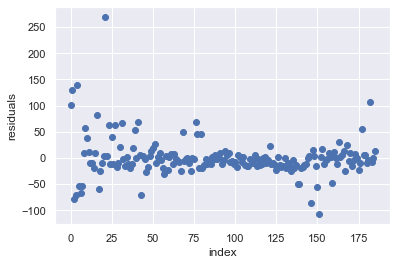

In [25]:
residuals = y_values - y_preds

plt.scatter(x = range(len(residuals)), y = residuals)
plt.xlabel('index')
plt.ylabel('residuals')

The following charts look at a specific feature used in the model compared to its associated residuals to evaluate constant variance.

Text(0, 0.5, 'residuals')

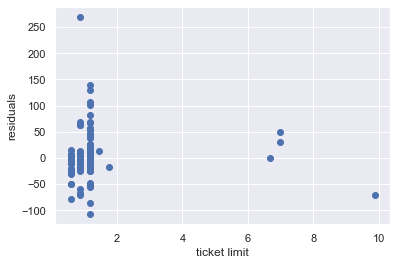

In [26]:
# check constant variance for ticket limit
plt.scatter(x = ticket_limit, y = residuals)
plt.xlabel('ticket limit')
plt.ylabel('residuals')

Text(0, 0.5, 'residuals')

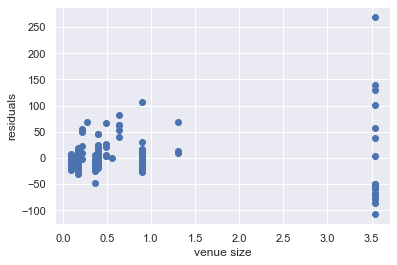

In [27]:
# check constant variance for venue size
plt.scatter(x = venue_size, y = residuals)
plt.xlabel('venue size')
plt.ylabel('residuals')

Text(0.5, 0.98, 'Constant variance plots for genre')

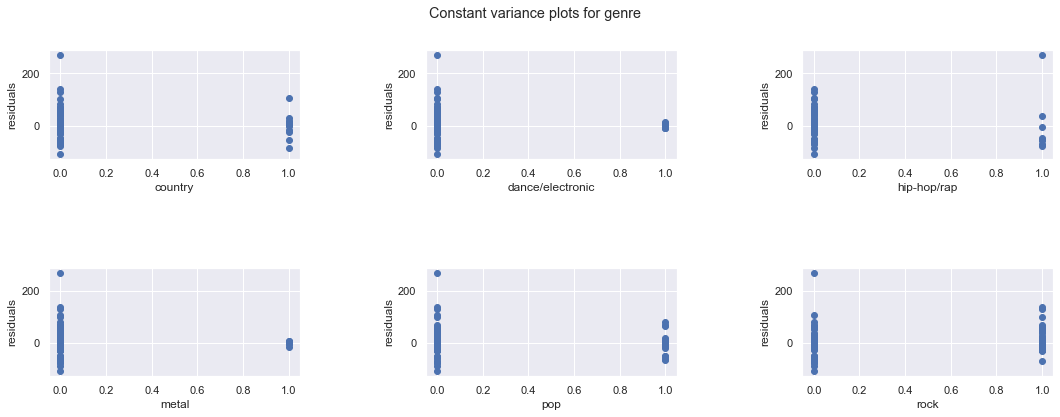

In [28]:
# index into X values matrix to obtain genre data
country = X_values[:, 2]
dance_electronic = X_values[:, 3]
hip_hop_rap = X_values[:, 4]
metal = X_values[:, 5]
pop = X_values[:, 6]
rock = X_values[:, 7]

# create lists of genre names and data
genres = ['country', 'dance/electronic', 'hip-hop/rap', 'metal', 'pop', 'rock']
genres_data = [country, dance_electronic, hip_hop_rap, metal, pop, rock]

# iterate through genres
for i in range(len(genres)):
    
    # plot residuals vs genre data
    plt.subplot(2, 3, i+1)
    plt.scatter(x = genres_data[i], y = residuals)
    plt.xlabel(genres[i])
    plt.ylabel('residuals')
    
# adjust figure overall
plt.gcf().set_size_inches(18, 6)
plt.subplots_adjust(wspace=.5, hspace=1)
plt.suptitle('Constant variance plots for genre')

Text(0.5, 0.98, 'constant variance plots for season')

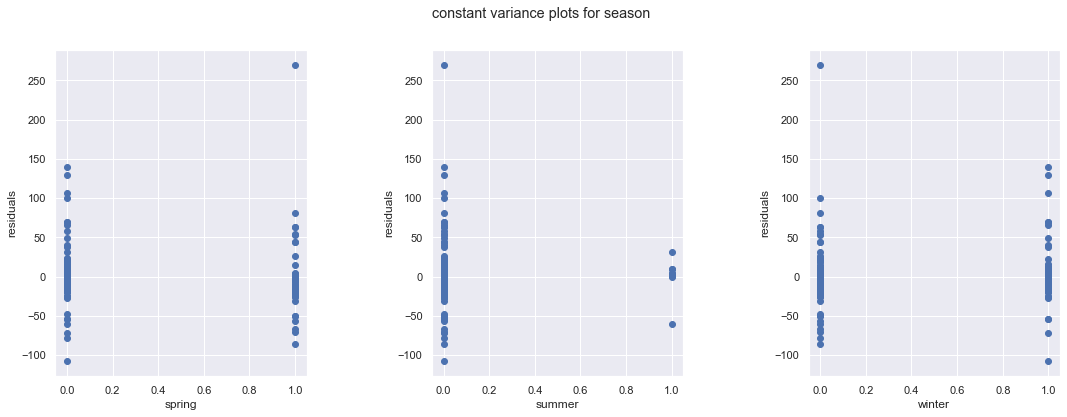

In [29]:
# index into X values matrix to obtain seasons data
spring = X_values[:, -3]
summer = X_values[:, -2]
winter = X_values[:, -1]

# create lists of season names and data
seasons = ['spring', 'summer', 'winter']
seasons_data = [spring, summer, winter]

# iterate through seasons
for i in range(len(seasons)):
    
    # plot residuals vs season data
    plt.subplot(1, 3, i+1)
    plt.scatter(x = seasons_data[i], y = residuals)
    plt.xlabel(seasons[i])
    plt.ylabel('residuals')
    
# adjust figure overall
plt.gcf().set_size_inches(18, 6)
plt.subplots_adjust(wspace=.5, hspace=1)
plt.suptitle('constant variance plots for season')

Finally, we looked at the probability plot to assess how normally distributed our residuals are.

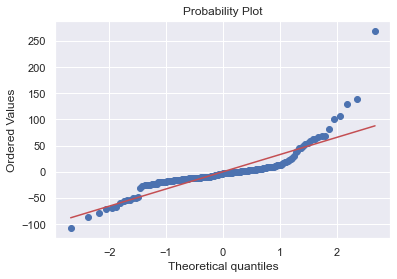

In [30]:
stats.probplot(residuals, dist="norm", plot=py)
py.show()

#### Remaking model

After being dissatsified with the residual plots generated by our model (see description in report), we decided to try fitting the data to predict the log transformed version of our average price data and hopefully create a model that better satisfies the assumptions of the linear regression. This is followed up by performing LOOCV to this new model and looking at new residual plots.

In [31]:
# obtain log y values using the transformed price feature (that we created earlier)
y_values_log = ticketmaster_df.price_transformed.to_numpy()

In [32]:
# conduct LOO cross validation

# set up the array of predictions to fill out
y_preds = np.empty(len(X_values))

# loop through each observation
for obs in range(len(X_values)):
    # the below excludes the single row/true y belonging to obs as well as the bias column
    mult_trainX = np.concatenate((X_values[:obs, :], X_values[obs+1:, :]))
    mult_trainy = np.concatenate((y_values_log[:obs], y_values_log[obs+1:]))
    
    # then train the model
    loocv_regress = LinearRegression()
    loocv_regress.fit(mult_trainX, mult_trainy)
    
    # and predict the held out observation (and store it)
    y_preds[obs] = loocv_regress.predict(X_values[obs, :].reshape(-1, 11))[0]

r2_score(y_values_log, y_preds)

0.5492950412752827

In [33]:
# fit model to overall data
model = LinearRegression()
model.fit(X_values, y_values_log)
y_preds = model.predict(X_values)

print('MSE: ' + str(get_mse(y_values_log, y_preds)))
print('R-squared: ' + str(r2_score(y_values_log, y_preds)))

MSE: 0.1843140424371827
R-squared: 0.6142683920038254


#### Analyzing coefficients

The order of the coefficients is the following:
ticket_limit, venue_size, genre_country, genre_dance/electronic, genre_hiphop/rap, genre_metal, genre_pop, genre_rock, season_spring, season_summer, season_winter.

In [34]:
model.coef_

array([-0.0233339 ,  0.49549938,  0.07197984, -0.15274507,  0.07947168,
       -0.17943127, -0.36956856, -0.09562411,  0.252962  ,  0.34416158,
        0.138917  ])

In [35]:
model.intercept_

3.4512790687240105

#### Residual plots

The following plots show the distribution of the residuals for our updated linear regression.

Text(0, 0.5, 'residuals')

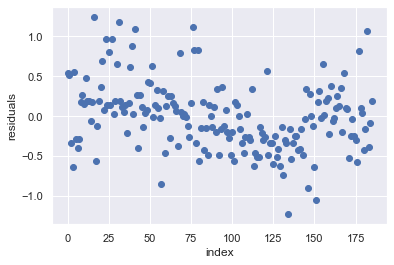

In [36]:
residuals = y_values_log - y_preds

# check for independence 
plt.scatter(x = range(len(residuals)), y = residuals)
plt.xlabel('index')
plt.ylabel('residuals')

Text(0, 0.5, 'residuals')

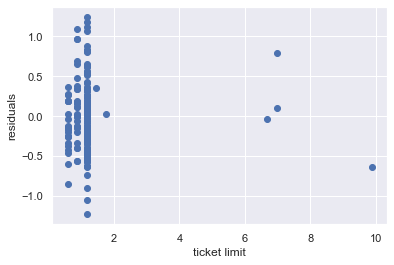

In [37]:
# check constant variance for ticket limit
plt.scatter(x = ticket_limit, y = residuals)
plt.xlabel('ticket limit')
plt.ylabel('residuals')

Text(0, 0.5, 'residuals')

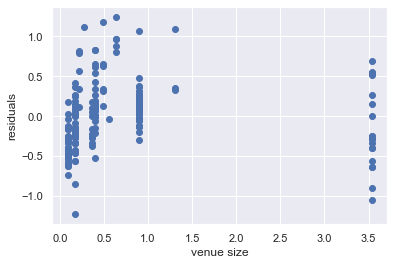

In [38]:
# check constant variance for venue size
plt.scatter(x = venue_size, y = residuals)
plt.xlabel('venue size')
plt.ylabel('residuals')

Text(0.5, 0.98, 'Constant variance plots for genre')

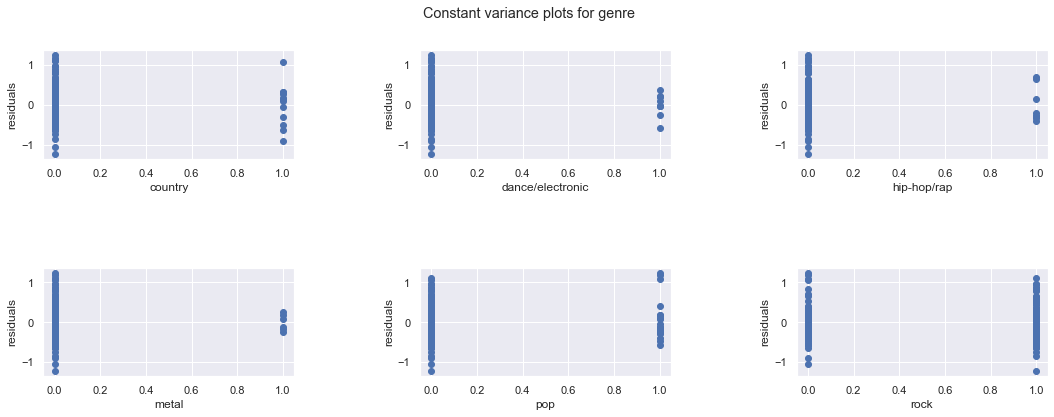

In [39]:
# index into X values matrix to obtain genre data
country = X_values[:, 2]
dance_electronic = X_values[:, 3]
hip_hop_rap = X_values[:, 4]
metal = X_values[:, 5]
pop = X_values[:, 6]
rock = X_values[:, 7]

# create lists of genre names and data
genres = ['country', 'dance/electronic', 'hip-hop/rap', 'metal', 'pop', 'rock']
genres_data = [country, dance_electronic, hip_hop_rap, metal, pop, rock]

# iterate through genres
for i in range(len(genres)):
    
    # plot residuals vs genre data
    plt.subplot(2, 3, i+1)
    plt.scatter(x = genres_data[i], y = residuals)
    plt.xlabel(genres[i])
    plt.ylabel('residuals')
    
# adjust figure overall
plt.gcf().set_size_inches(18, 6)
plt.subplots_adjust(wspace=.5, hspace=1)
plt.suptitle('Constant variance plots for genre')

Text(0.5, 0.98, 'constant variance plots for season')

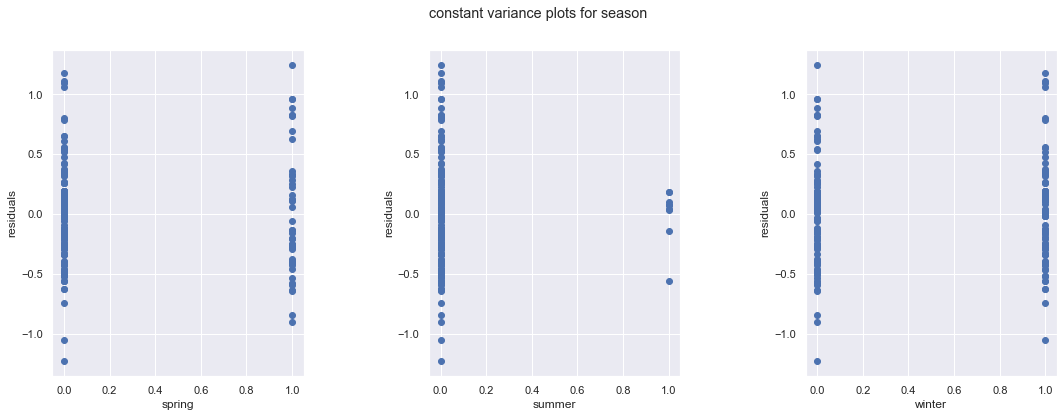

In [40]:
# index into X values matrix to obtain seasons data
spring = X_values[:, -3]
summer = X_values[:, -2]
winter = X_values[:, -1]

# create lists of season names and data
seasons = ['spring', 'summer', 'winter']
seasons_data = [spring, summer, winter]

# iterate through seasons
for i in range(len(seasons)):
    
    # plot residuals vs season data
    plt.subplot(1, 3, i+1)
    plt.scatter(x = seasons_data[i], y = residuals)
    plt.xlabel(seasons[i])
    plt.ylabel('residuals')
    
# adjust figure overall
plt.gcf().set_size_inches(18, 6)
plt.subplots_adjust(wspace=.5, hspace=1)
plt.suptitle('constant variance plots for season')

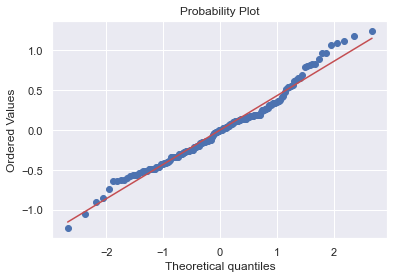

In [41]:
# normality plot
stats.probplot(residuals, dist="norm", plot=py)
py.show()